In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from dataclasses import dataclass


## Parameters

In [3]:
@dataclass
class NeuronParams:
    tau_m: float = 10.0     # membrane time constant (ms)
    E_L: float = -65.0      # resting potential (mV)
    R_m: float = 10.0       # membrane resistance (MΩ)
    V_th: float = -50.0     # spike threshold (mV)
    V_reset: float = -65.0  # reset potential (mV)
    V_peak: float = 0.0     # spike peak (mV)

@dataclass
class SynapseParams:
    tau_s: float = 5.0      # synaptic time constant (ms)
    g_bar: float = 0.05     # max syn. conductance (µS)
    P_max: float = 1.0      # max synaptic activation
    E_rev: float = 0.0      # reversal potential (mV)

## Neuron and Synapse Classes

In [4]:
class Synapse:
    """Handles decay and jump of synaptic activation."""
    def __init__(self, params: SynapseParams):
        self.params = params
        self.P = 0.0

    def step(self, spike: bool, dt: float):
        # exponential decay
        self.P -= (self.P / self.params.tau_s) * dt
        # jump on presynaptic spike
        if spike:
            self.P += self.params.P_max * (1.0 - self.P)
        return self.P

class Neuron:
    """Leaky‐integrate‐and‐fire neuron with RK4 integration."""
    def __init__(self, params: NeuronParams, dt: float):
        self.p = params
        self.dt = dt
        self.V = params.E_L

    def _dVdt(self, I_ext: float, syn_cond: float, E_rev: float):
        """Compute dV/dt given external current and synaptic conductance."""
        leak        = self.p.E_L - self.V
        syn_current = self.p.R_m * syn_cond * (self.V - E_rev)
        return (leak + syn_current + self.p.R_m * I_ext) / self.p.tau_m

    def rk4_step(self, I_ext: float, syn_cond: float, E_rev: float):
        """One RK4 integration step."""
        f = lambda V: (self.p.E_L - V + 
                      self.p.R_m * syn_cond * (V - E_rev) +
                      self.p.R_m * I_ext) / self.p.tau_m

        k1 = f(self.V) * self.dt
        k2 = f(self.V + 0.5*k1) * self.dt
        k3 = f(self.V + 0.5*k2) * self.dt
        k4 = f(self.V + k3) * self.dt

        self.V += (k1 + 2*k2 + 2*k3 + k4) / 6.0
        return self.V

    def step(self, I_ext: float, syn: Synapse, E_rev: float):
        """
        Advance voltage one time‐step.
        Returns: (is_spike, V_to_plot)
        """
        V_next = self.rk4_step(I_ext, syn.P * syn.params.g_bar, E_rev)

        if V_next >= self.p.V_th:
            # emit spike
            self.V = self.p.V_reset
            return True, self.p.V_peak
        else:
            self.V = V_next
            return False, V_next


## Setup

In [5]:
dt = 0.1
T  = 500
time = np.arange(0, T + dt, dt)

# input currents (smoothed noise)
np.random.seed(0)
def noisy_current(size):
    return 1.5 + gaussian_filter1d(np.random.randn(size), sigma=150) * 12

I_A = noisy_current(len(time))
I_B = noisy_current(len(time))

# instantiate neuron & synapse objects
n_params = NeuronParams()
s_params_AtoB = SynapseParams(E_rev=0.0) # excitatory
s_params_BtoA = SynapseParams(E_rev=-80.0) # inhibitory

neuron_A = Neuron(n_params, dt)
neuron_B = Neuron(n_params, dt)

syn_AtoB = Synapse(s_params_AtoB)
syn_BtoA = Synapse(s_params_BtoA)

# storage arrays
V_A_plot       = np.full_like(time, n_params.E_L)
V_B_plot       = np.full_like(time, n_params.E_L)
P_AtoB_trace   = np.zeros_like(time)
P_BtoA_trace   = np.zeros_like(time)


## Simulation

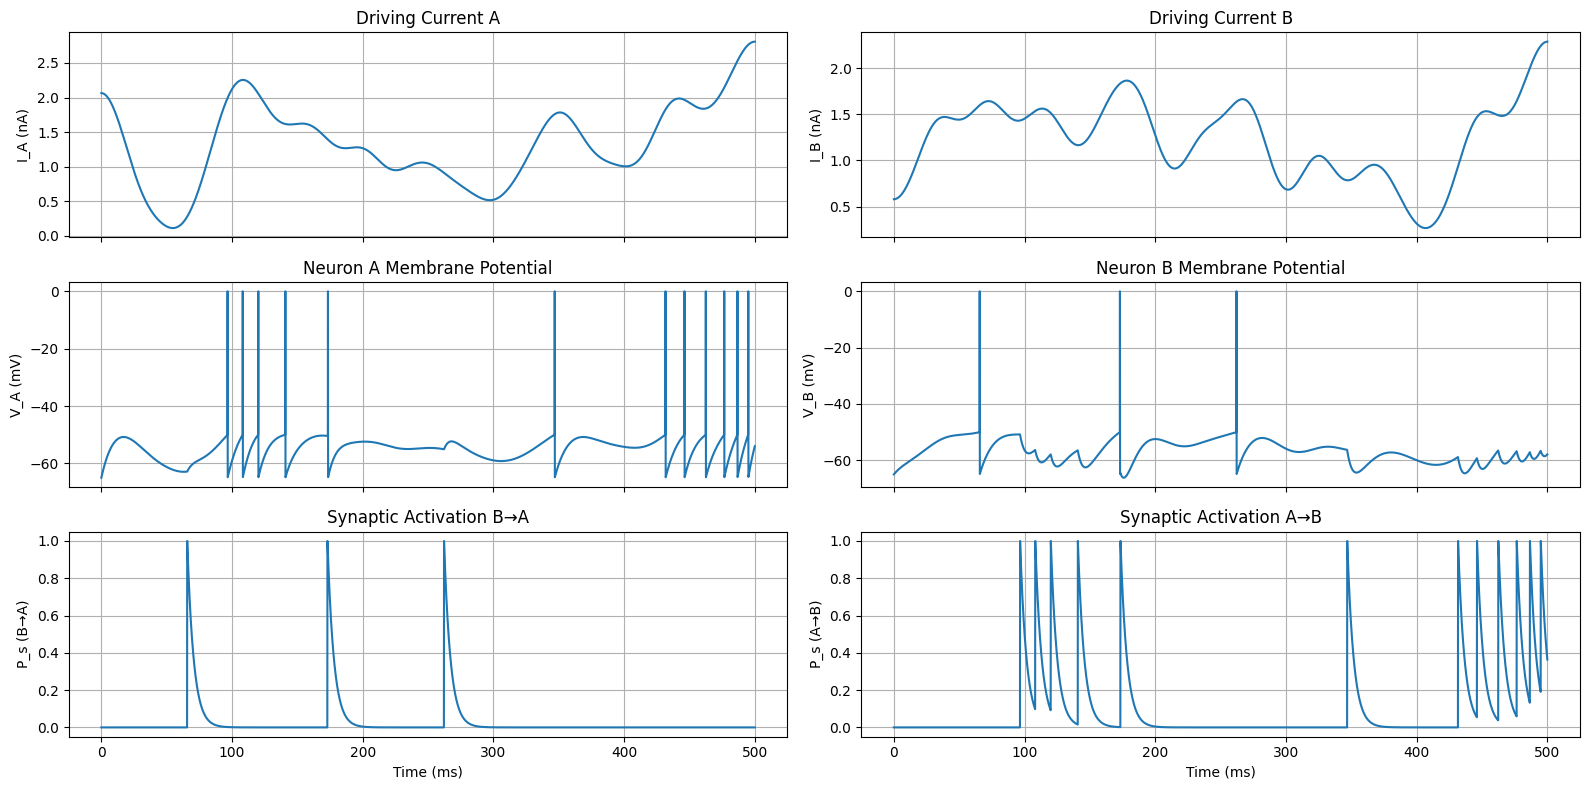

In [ ]:
for i, t in enumerate(time[1:], start=1):
    # A → B path
    spike_A, V_A_plot[i] = neuron_A.step(I_A[i], syn_BtoA, s_params_BtoA.E_rev)
    P_AtoB_trace[i]      = syn_AtoB.step(spike_A, dt)

    # B → A path
    spike_B, V_B_plot[i] = neuron_B.step(I_B[i], syn_AtoB, s_params_AtoB.E_rev)
    P_BtoA_trace[i]      = syn_BtoA.step(spike_B, dt)


In [ ]:
def plot_traces(time, V_A, I_A, P_AtoB, V_B, I_B, P_BtoA):
    fig, axes = plt.subplots(3, 2, figsize=(16, 8), sharex=True)

    # Driving Currents
    axes[0, 0].plot(time, I_A)
    axes[0, 0].set_ylabel('I_A (nA)')
    axes[0, 0].set_title('Driving Current A')

    axes[0, 1].plot(time, I_B)
    axes[0, 1].set_ylabel('I_B (nA)')
    axes[0, 1].set_title('Driving Current B')

    # Membrane Potentials
    axes[1, 0].plot(time, V_A)
    axes[1, 0].set_ylabel('V_A (mV)')
    axes[1, 0].set_title('Neuron A Membrane Potential')

    axes[1, 1].plot(time, V_B)
    axes[1, 1].set_ylabel('V_B (mV)')
    axes[1, 1].set_title('Neuron B Membrane Potential')

    # Synaptic Activations
    axes[2, 0].plot(time, P_BtoA)
    axes[2, 0].set_ylabel('P_s (B→A)')
    axes[2, 0].set_xlabel('Time (ms)')
    axes[2, 0].set_title('Synaptic Activation B→A')
    
    axes[2, 1].plot(time, P_AtoB)
    axes[2, 1].set_ylabel('P_s (A→B)')
    axes[2, 1].set_xlabel('Time (ms)')
    axes[2, 1].set_title('Synaptic Activation A→B')

    for ax in axes.flatten():
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_traces(time, V_A_plot, I_A, P_AtoB_trace, V_B_plot, I_B, P_BtoA_trace)